## Training: Fitness Function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.surrogate_model import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *

#### Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

#### Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="data/fitness_function")
test_dataset = DatasetFF(train=False, path="data/fitness_function")

In [4]:
train_dataset.X[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.8444,  0.7580,
         0.4206,  0.2589,  0.5113,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.4049,  0.7838,  0.3033,  0.4766, -1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.9081,
         0.5047,  0.2818, -1.0000, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.2505,  0.9097,  0.9828, -1.0000, -1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.3101,  0.7298,  0.8988,
         0.6840,  0.4721,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.1007,  0.4342,  0.6109,  0.9130, -1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -2.4871,  0.9544,  5.2624, -2.8066, -3.1369,  1.4458,  2.5343, -1.3972,
         4.1084, -0.7300, -1.2096, -2.14

In [5]:
train_dataset.y

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 1., 0.],
        ...,
        [0., 0., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 0.]])

#### Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, FEATURE_ID_TO_SCALE])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [7]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  2.4942, -1.3108, -0.3374],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4942, -1.3108, -0.3374],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4942, -1.3108, -0.3374],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  2.5029, -0.3785, -1.9187],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.5029, -0.3785, -1.9187],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.5029, -0.3785, -1.9187]])

#### Build model and switch to GPU if available

In [8]:
fitness_function = FitnessFunction(hidden_sizes=[120, 84])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=120, out_features=84, bias=True)
  )
  (out): Linear(in_features=84, out_features=4, bias=True)
)

In [9]:
fitness_function(test_dataset.X[0])

tensor([0.4653, 0.5532, 0.4927, 0.5753], grad_fn=<SigmoidBackward>)

#### Define loss function and optimizer

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### Define Data loaders

In [11]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [12]:
n_epochs = 1

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = fitness_function(inputs)
        print(outputs)
        print(targets)
        loss = criterion(outputs, targets)
        print(loss)
        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    if (it + 1) % 1 == 0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

tensor([[0.4749, 0.5040, 0.5013, 0.5966],
        [0.4071, 0.4103, 0.5067, 0.6204],
        [0.4590, 0.4365, 0.4635, 0.4867],
        [0.5088, 0.5201, 0.4774, 0.5624],
        [0.4219, 0.4990, 0.4610, 0.5837],
        [0.4559, 0.5579, 0.4842, 0.6186],
        [0.5029, 0.5073, 0.4801, 0.6069],
        [0.4535, 0.4643, 0.5270, 0.5619],
        [0.4264, 0.4206, 0.5150, 0.5345],
        [0.4924, 0.5534, 0.4870, 0.5184],
        [   nan,    nan,    nan,    nan],
        [0.4232, 0.4533, 0.5213, 0.5636],
        [0.4231, 0.5221, 0.5323, 0.5948],
        [0.4121, 0.5748, 0.4994, 0.5340],
        [0.4128, 0.5462, 0.5963, 0.6119],
        [0.4906, 0.4937, 0.5016, 0.6062],
        [0.4693, 0.5234, 0.5064, 0.6079],
        [   nan,    nan,    nan,    nan],
        [0.4631, 0.5507, 0.4766, 0.5773],
        [0.5083, 0.5892, 0.4931, 0.5240],
        [0.4580, 0.5248, 0.4712, 0.5525],
        [0.4683, 0.5311, 0.5236, 0.6076],
        [0.5017, 0.5205, 0.4527, 0.5695],
        [0.4498, 0.4678, 0.4647, 0

#### Plot the train loss and test loss per iteration

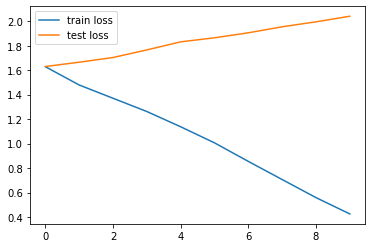

In [11]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### Save trained model

In [18]:
torch.save(fitness_function.state_dict(), "../models/best_fitness_function.pth")

#### Load model and make predictions

In [29]:
model = FitnessFunction(hidden_sizes=[98, 69])
model.load_state_dict(torch.load("../models/best_fitness_function.pth"))
model.eval()

FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=360, out_features=245, bias=True)
  )
  (out): Linear(in_features=245, out_features=5, bias=True)
)

In [28]:
random_input = torch.from_numpy(np.random.normal(size=[1, 98]).astype(np.float32))

output = model(random_input)

tensor([[ 0.0636, -2.3131,  0.8815, -0.8085, -0.2552]],
       grad_fn=<AddmmBackward>)


tensor(2)

In [ ]:
output

In [ ]:
decode_classes(output)